# MTA Challenges: Pandas

## Solve Challenges using Pandas in order to facilitate project Benson 

### Mitchell Lee: July 12, 2017

#### Import usful packages and set pandas preferences

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.precision', 3)

#### Define some usful functions

In [2]:
def clean_cols(df):
    for col in df.columns:
        # Clean the string type data
        if df[col].dtype == 'object':
            df[col]= df[col].str.strip()
    return df

def make_standard_names(df):
    # Clean up the column names
    cols = df.columns
    for col in cols:
        col_new = col
        col_new = col_new.lower()
        col_new = col_new.strip()
        col_new = col_new.replace('/','')
        col_new = col_new.replace(' ','_')
        df = df.rename(columns = {col: col_new})
    return df

def make_id(df):
    df['id'] = df['ca']+'_'+ df['unit'] +'_'+df['scp']+'_'+df['station']
    return df

# Question 1

In [3]:
# Get a list of files
flist = glob.glob('turnstile*.txt')
#flist.sort(reverse=True)
flist.sort()
#flist = flist[1:-2]

In [4]:
# Open dataframe and run simple clean ups
nyc_df = pd.read_csv(flist[-1])

In [5]:
# Create a unique "Meter Name"
# 'ca', 'unit','scp' comprise a unique "meters".
# There can be several "meters" at each station. 
# This these can be recombined using "Group By"

def clean_up(df):
    df = clean_cols(df)
    df = make_standard_names(df)
    df = make_id(df)
    
    # Make datetime column
    df['readtime'] = df['date'] + ' ' + df['time']
    df['readtime'] = pd.to_datetime(df['readtime'], format='%m/%d/%Y %H:%M:%S')
    
    df = df.sort_values(['station','scp','ca','readtime'])
    
    
    # Remove Audit Hours
    df = df[df['desc'] != 'RECOVR AUD']

    # Calculate riders entering and exiting for each hour
    df['entries_diff'] = df['entries'].diff()
    df['exits_diff'] = df['exits'].diff()

    # Filter out "impossible values"
    lower_lim = 0
    upper_lim = 60*60*2 # One rider every 2 second for 4 hours

    # Clean up jump that results in diff when going from one meter to another
    # To do this, I converted the "ids", exits, and entries to lists, and the I
    # I used a simple "for loop".
    id_list = list(df['id'])
    entries_diff_list = list(df.entries_diff)
    exits_diff_list = list(df.exits_diff)

    for ix, val in enumerate(id_list):
        if ix!= 0:
            if id_list[ix]!= id_list[ix-1]:
                entries_diff_list[ix] = np.nan
                exits_diff_list[ix] = np.nan

    for ix, val in enumerate(entries_diff_list):
        if val> upper_lim:
            entries_diff_list[ix] = np.nan
        elif val<0:
            entries_diff_list[ix] = np.nan

    for ix, val in enumerate(exits_diff_list):
        if val> upper_lim:
            exits_diff_list[ix] = np.nan
        elif val<0:
            exits_diff_list[ix] = np.nan

    # Put cleaned values back in the data frame

    df['entries_diff_cleaned'] = entries_diff_list
    df['exits_diff_cleaned'] = exits_diff_list
    df['total_traffic'] = df['entries_diff_cleaned'] + df['exits_diff_cleaned'] 
        
    df['lunch_entries'] = np.where(
    (df['readtime'].dt.hour >= 11) & (df['readtime'].dt.hour <= 16), 
    df['entries_diff_cleaned'], 0)

    df['lunch_exits'] = np.where(
    (df['readtime'].dt.hour >= 11) & (df['readtime'].dt.hour <= 16), 
    df['exits_diff_cleaned'], 0)

    df['dinner_entries'] = np.where(
    df['readtime'].dt.hour >= 17, 
    df['entries_diff_cleaned'], 0)
    
    df['dinner_exits'] = np.where(
    df['readtime'].dt.hour >= 17, 
    df['exits_diff_cleaned'], 0)
    
    df['total_lunch_traffic'] = df['lunch_entries'] + df['lunch_exits']
    df['total_dinner_traffic'] = df['dinner_entries'] + df['dinner_exits']
    
    df['lines_at_station'] = df.linename.apply(len)
    
    return df


In [6]:
nyc_df = clean_up(nyc_df)

In [7]:
turnstile_grouped = nyc_df.groupby('id')
turnstile_grouped.sum().iloc[0:10]
#turnstile_grouped.median()

,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,total_traffic,lunch_entries,lunch_exits,dinner_entries,dinner_exits,total_lunch_traffic,total_dinner_traffic,lines_at_station
id,,,,,,,,,,,,,,
A002_R051_02-00-00_59 ST,287247273,97265652,6.042e+06,-7.280e+05,6940.0,2333.0,9273.0,2522.0,1473.0,3180.0,280.0,3995.0,3460.0,322
A002_R051_02-00-01_59 ST,259372361,57657232,-6.068e+05,-8.616e+05,5595.0,1462.0,7057.0,2000.0,869.0,2602.0,254.0,2869.0,2856.0,322
A002_R051_02-03-00_59 ST,43156695,160016332,-4.702e+06,2.230e+06,2816.0,9961.0,12777.0,1030.0,5383.0,1210.0,2682.0,6413.0,3892.0,322
A002_R051_02-03-01_59 ST,15575064,24893624,-5.897e+05,-2.925e+06,7319.0,10237.0,17556.0,2841.0,5670.0,2874.0,2604.0,8511.0,5478.0,315
A002_R051_02-03-02_59 ST,249694556,343625662,5.082e+06,6.915e+06,7161.0,7556.0,14717.0,2803.0,4092.0,2865.0,1523.0,6895.0,4388.0,322
A002_R051_02-03-03_59 ST,232681531,274811547,-3.703e+05,-1.497e+06,6249.0,5397.0,11646.0,2394.0,2961.0,2657.0,818.0,5355.0,3475.0,322
A002_R051_02-03-04_59 ST,292360255,155893015,1.298e+06,-2.587e+06,6784.0,2653.0,9437.0,2620.0,1398.0,2817.0,329.0,4018.0,3146.0,322
A002_R051_02-03-05_59 ST,471233295,60670971,3.891e+06,-2.071e+06,10693.0,679.0,11372.0,4338.0,358.0,3821.0,98.0,4696.0,3919.0,322
A002_R051_02-03-06_59 ST,370911449,22242138,-2.182e+06,-8.357e+05,7671.0,110.0,7781.0,2892.0,55.0,3133.0,25.0,2947.0,3158.0,322


# Question 2

In [8]:
turnstile_time_grouped = nyc_df.groupby(['id','readtime'])
turnstile_time_grouped.mean().iloc[0:10]

entries    exits  entries_diff  \
id                       readtime                                              
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00  6241669  2113493     6.035e+06   
                         2017-07-01 04:00:00  6241693  2113495     2.400e+01   
                         2017-07-01 08:00:00  6241706  2113522     1.300e+01   
                         2017-07-01 12:00:00  6241794  2113615     8.800e+01   
                         2017-07-01 16:00:00  6241992  2113666     1.980e+02   
                         2017-07-01 20:00:00  6242258  2113707     2.660e+02   
                         2017-07-02 00:00:00  6242391  2113725     1.330e+02   
                         2017-07-02 04:00:00  6242425  2113728     3.400e+01   
                         2017-07-02 08:00:00  6242442  2113753     1.700e+01   
                         2017-07-02 12:00:00  6242507  2113825     6.500e+01   

                                              exits_diff  \
id                       readtime                          
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00   -730299.0   
                         2017-07-01 04:00:00         2.0   
                         2017-07-01 08:00:00        27.0   
                         2017-07-01 12:00:00        93.0   
                         2017-07-01 16:00:00        51.0   
                         2017-07-01 20:00:00        41.0   
                         2017-07-02 00:00:00        18.0   
                         2017-07-02 04:00:00         3.0   
                         2017-07-02 08:00:00        25.0   
                         2017-07-02 12:00:00        72.0   

                                              entries_diff_cleaned  \
id                       readtime                                    
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00                   NaN   
                         2017-07-01 04:00:00                  24.0   
                         2017-07-01 08:00:00                  13.0   
                         2017-07-01 12:00:00                  88.0   
                         2017-07-01 16:00:00                 198.0   
                         2017-07-01 20:00:00                 266.0   
                         2017-07-02 00:00:00                 133.0   
                         2017-07-02 04:00:00                  34.0   
                         2017-07-02 08:00:00                  17.0   
                         2017-07-02 12:00:00                  65.0   

                                              exits_diff_cleaned  \
id                       readtime                                  
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00                 NaN   
                         2017-07-01 04:00:00                 2.0   
                         2017-07-01 08:00:00                27.0   
                         2017-07-01 12:00:00                93.0   
                         2017-07-01 16:00:00                51.0   
                         2017-07-01 20:00:00                41.0   
                         2017-07-02 00:00:00                18.0   
                         2017-07-02 04:00:00                 3.0   
                         2017-07-02 08:00:00                25.0   
                         2017-07-02 12:00:00                72.0   

                                              total_traffic  lunch_entries  \
id                       readtime                                            
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00            NaN            0.0   
                         2017-07-01 04:00:00           26.0            0.0   
                         2017-07-01 08:00:00           40.0            0.0   
                         2017-07-01 12:00:00          181.0           88.0   
                         2017-07-01 16:00:00          249.0          198.0   
                         2017-07-01 20:00:00          307.0            0.0   
                         2017-07-02 00:00:00          151.0            0.0   
    

# Question 3

n = ~4

In [9]:
turnstile_date_grouped = nyc_df.groupby(['ca','unit','scp','station','date'])
turnstile_date_summed = turnstile_date_grouped.sum().dropna()

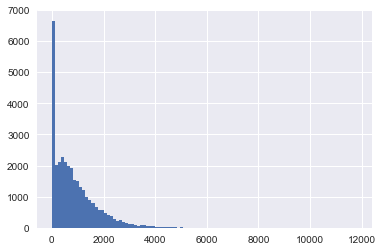

In [10]:
plt.hist(turnstile_date_summed['entries_diff_cleaned'],bins = 100)
plt.show()

In [11]:
turnstile_date_summed

entries     exits  \
ca    unit scp      station       date                             
A002  R051 02-00-00 59 ST         07/01/2017  37451112  12681498   
                                  07/02/2017  37455331  12682810   
                                  07/03/2017  37459533  12684396   
                                  07/04/2017  37465039  12685871   
                                  07/05/2017  56203584  19031260   
...                                                ...       ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 07/01/2017     33324      1809   
                                  07/02/2017     33324      1812   
                                  07/03/2017     22216      1208   
                                  07/04/2017     33324      1812   
                                  07/05/2017     27770      1510   

                                              entries_diff  exits_diff  \
ca    unit scp      station       date                                   
A002  R051 02-00-00 59 ST         07/01/2017     6.036e+06   -730085.0   
                                  07/02/2017     6.290e+02       201.0   
                                  07/03/2017     9.980e+02       314.0   
                                  07/04/2017     5.950e+02       176.0   
                                  07/05/2017     1.331e+03       475.0   
...                                                    ...         ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 07/01/2017     2.862e+03       240.0   
                                  07/02/2017     0.000e+00         0.0   
                                  07/03/2017     0.000e+00         0.0   
                                  07/04/2017     0.000e+00         0.0   
                                  07/05/2017     0.000e+00         0.0   

                                              entries_diff_cleaned  \
ca    unit scp      station       date                               
A002  R051 02-00-00 59 ST         07/01/2017                 589.0   
                                  07/02/2017                 629.0   
                                  07/03/2017                 998.0   
                                  07/04/2017                 595.0   
                                  07/05/2017                1331.0   
...                                                            ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 07/01/2017                   0.0   
                                  07/02/2017                   0.0   
                                  07/03/2017                   0.0   
                                  07/04/2017                   0.0   
                                  07/05/2017                   0.0   

                                              exits_diff_cleaned  \
ca    unit scp      station       date                             
A002  R051 02-00-00 59 ST         07/01/2017               214.0   
                                  07/02/2017               201.0   
                                  07/03/2017               314.0   
                                  07/04/2017               176.0   
                                  07/05/2017               475.0   
...                                                          ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 07/01/2017                 1.0   
                                  07/02/2017                 0.0   
                                  07/03/2017                 0.0   
                                  07/04/2017                 0.0   
                                  07/05/2017                 0.0   

                                              total_traffic  lunch_entries  \
ca    unit scp      station       date                                       
A002  R051 02-00-00 59 ST         07/01/2017          803.0          286.0   
                                  07/02/2017          830.0          237.0   
                                  07/03/2017         1312.0          427.0   
             

# Question 4
#### Plot the daily time series for a turnstile.

In [12]:
# matplotlib import and set up done at top of file

# Reset index to make querying easier
turnstile_date_summed = turnstile_date_summed.reset_index()
turnstile_date_summed = make_id(turnstile_date_summed)

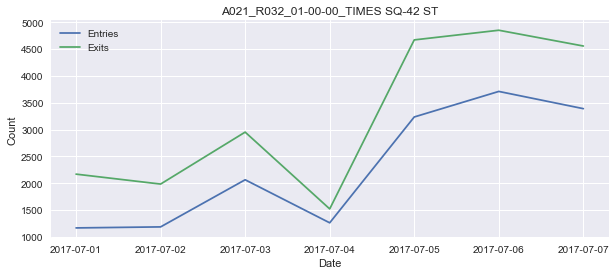

In [13]:
test_turnstile = turnstile_date_summed['id'][420]

single_turnstile = turnstile_date_summed[turnstile_date_summed['id'] == test_turnstile]

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(pd.to_datetime(single_turnstile['date']),single_turnstile['entries_diff_cleaned'])
plt.plot(pd.to_datetime(single_turnstile['date']),single_turnstile['exits_diff_cleaned'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Entries','Exits'])
plt.title(test_turnstile)

In [14]:
#turnstile_date_summed[turnstile_date_summed['id'].str.contains('42')]

# Question 5
#### Group by ControlArea/Unit/Station (i.e. substation)

In [15]:
substation_date_summed = turnstile_date_summed.groupby(['ca','unit','station']).sum()
substation_date_summed

,,,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,total_traffic,lunch_entries,lunch_exits,dinner_entries,dinner_exits,total_lunch_traffic,total_dinner_traffic,lines_at_station
ca,unit,station,,,,,,,,,,,,,,
A002,R051,59 ST,2549405278,1204083191,6.909e+06,-2.692e+06,68859.0,40537.0,109396.0,26662.0,22315.0,28059.0,8657.0,48977.0,36716.0,3857
A006,R079,5 AV/59 ST,1980843413,1998049043,1.043e+07,1.266e+07,57295.0,41799.0,99094.0,7620.0,11698.0,44787.0,13071.0,19318.0,57858.0,1344
A007,R079,5 AV/59 ST,5683213803,536107727,-8.002e+06,-1.238e+07,31873.0,22182.0,54055.0,4731.0,7345.0,24236.0,9175.0,12076.0,33411.0,1032
A010,R080,57 ST-7 AV,3414996352,1047851418,2.685e+07,5.288e+06,95396.0,32145.0,127541.0,38542.0,18291.0,37630.0,6298.0,56833.0,43928.0,1420
A011,R080,57 ST-7 AV,72623100901,60331732360,-9.865e+08,-4.560e+08,47332.0,44643.0,91975.0,16991.0,25326.0,21799.0,9710.0,42317.0,31509.0,736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S101,R070,ST. GEORGE,718742399,960582,1.302e+06,-1.300e+01,30747.0,0.0,30747.0,13492.0,0.0,3875.0,0.0,13492.0,3875.0,546
S101A,R070,ST. GEORGE,4222572051,3249288,-1.301e+06,-2.200e+02,32482.0,0.0,32482.0,7578.0,0.0,17867.0,0.0,7578.0,17867.0,546
S102,R165,TOMPKINSVILLE,390492781,104182596,5.600e+01,-8.540e+02,4207.0,0.0,4207.0,788.0,0.0,1849.0,0.0,788.0,1849.0,294


# Question 6
#### Group by station

There are many many duplicate stations in new york city.
i.e. there are several stations called 125th street

According to:
https://data.ny.gov/Transportation/Turnstile-Usage-Data-2016/ekwu-khcy/about, 'unit' is the true eqivalent of a station. Thus I am going to use groupby(unit,station,date) to get daily data aggregated by station.

In [16]:
station_date_summed = turnstile_date_summed.groupby(['unit','station','date']).sum().reset_index()

# Question 7
#### Plot timeseries for a single station

In [17]:
#station_date_summed[station_date_summed['station'].str.contains('125')]

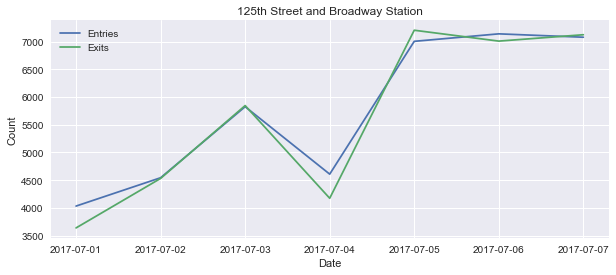

In [18]:
# According to http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls
# I used to live near the 'Unit = R034' station

mitch_rows = (station_date_summed['unit'] == 'R034') & (station_date_summed['station'] == '125 ST')
mitch_station = station_date_summed.loc[(mitch_rows)]

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(pd.to_datetime(mitch_station['date']),mitch_station['entries_diff_cleaned'])
plt.plot(pd.to_datetime(mitch_station['date']),mitch_station['exits_diff_cleaned'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Entries','Exits'])
plt.title('125th Street and Broadway Station')

# Question 8

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

---
All previous code was written assuming that I was working with one week.  Time to go back and "functionalize" previous work so that I can reuse it.

In [59]:
# loop through downloaded turnstile file
# This might take awhile
for ix, fname in enumerate(flist):
    new_df = pd.read_csv(fname)
    new_df_cleaned = clean_up(new_df)
    
    if ix == 0:
        total_df_cleaned = new_df_cleaned 
        station_daily = new_df_cleaned.groupby(['unit','station','date']).sum().reset_index()
        turnstile_daily = new_df_cleaned.groupby(['ca', 'unit', 'scp', 'station', 'date']).sum().reset_index()
    else:
        total_df_cleaned = total_df_cleaned.append(new_df_cleaned)
        station_daily = station_daily.append(
            new_df_cleaned.groupby(['unit','station','date']).sum().reset_index(),ignore_index=True)
        turnstile_daily = turnstile_daily.append(
            new_df_cleaned.groupby(['ca', 'unit', 'scp', 'station', 'date']).sum().reset_index(),ignore_index=True)

In [20]:
# Date Time Handeling 
station_daily['dtime'] = pd.to_datetime(station_daily['date'])
station_daily['week'] = station_daily['dtime'].dt.week
station_daily['day'] = station_daily['dtime'].dt.dayofweek

weeks = station_daily['week'].unique()

In [21]:
# Investigate 125th St and Broadway station again
mitch_rows2 = (station_daily['unit'] == 'R034') & (station_daily['station'] == '125 ST')
mitch_station2 = station_daily.loc[(mitch_rows2)]

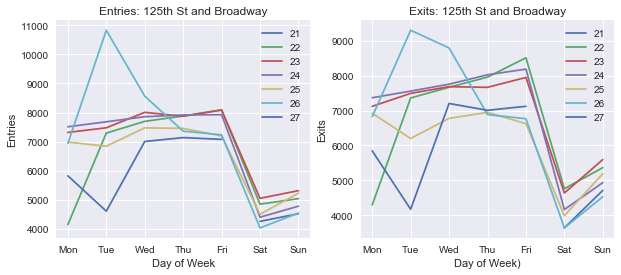

In [22]:
def make_rainbow_plot(df,title):
    fig, ax = plt.subplots(1,2, figsize=(10, 4))

    # Entries
    for w in weeks:
        week_df = df[df['week'] == w]
        ax[0].plot(week_df.day,week_df.entries_diff_cleaned)

    ax[0].set_title('Entries: ' + title)
    ax[0].set_xlabel('Day of Week')
    ax[0].set_ylabel('Entries')
    ax[0].set_xticks(range(0,7))
    ax[0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax[0].legend(weeks)

    # Exits 
    for w in weeks:
        week_df = df[df['week'] == w]
        ax[1].plot(week_df.day,week_df.exits_diff_cleaned)

    ax[1].set_title('Exits: ' + title)
    ax[1].set_xlabel('Day of Week)')
    ax[1].set_ylabel('Exits')
    ax[1].set_xticks(range(0,7))
    ax[1].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax[1].legend(weeks)
    
make_rainbow_plot(mitch_station2,'125th St and Broadway')

# Question 9

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

---
No need to reopen all of the files. Daily summed data can be aggregated without issue.


In [23]:
stations_summed = station_daily.groupby(['unit','station']).sum().reset_index()
stations_summed = stations_summed.sort_values('entries_diff_cleaned',ascending=False)
stations_summed['station_unit'] = stations_summed['station'] + '_' + stations_summed['unit']

In [24]:
stations_summed.iloc[:10]

,unit,station,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,total_traffic,lunch_entries,lunch_exits,dinner_entries,dinner_exits,total_lunch_traffic,total_dinner_traffic,lines_at_station,week,day,station_unit
166,R170,14 ST-UNION SQ,272464639330,78355435338,1.143e+08,1.486e+07,3.806e+06,3.308e+06,7.114e+06,5.259e+05,8.961e+05,2.415e+06,1.638e+06,1.422e+06,4.054e+06,75928,1017,126,14 ST-UNION SQ_R170
22,R022,34 ST-HERALD SQ,574817185016,621077220904,-8.425e+09,-1.256e+10,2.555e+06,2.155e+06,4.651e+06,9.318e+05,1.213e+06,1.107e+06,5.590e+05,2.113e+06,1.651e+06,66832,1017,126,34 ST-HERALD SQ_R022
48,R046,GRD CNTRL-42 ST,208414297345,188772747919,1.108e+08,-1.661e+08,2.532e+06,2.209e+06,4.740e+06,1.090e+06,1.151e+06,9.283e+05,6.082e+05,2.241e+06,1.537e+06,41260,1017,126,GRD CNTRL-42 ST_R046
79,R084,59 ST COLUMBUS,854922236065,750302048897,6.621e+08,-9.058e+05,2.457e+06,1.976e+06,4.433e+06,9.699e+05,1.124e+06,9.738e+05,4.710e+05,2.094e+06,1.445e+06,51690,1017,126,59 ST COLUMBUS_R084
34,R033,TIMES SQ-42 ST,1001180838393,838669897096,2.208e+10,1.061e+10,2.291e+06,1.523e+06,3.766e+06,7.269e+05,7.902e+05,8.064e+05,4.126e+05,1.488e+06,1.207e+06,77265,1017,126,TIMES SQ-42 ST_R033
57,R055,FLUSHING-MAIN,49060817023,48109114558,-9.618e+06,-1.496e+07,2.141e+06,1.666e+06,3.807e+06,1.048e+06,5.932e+05,4.662e+05,6.250e+05,1.641e+06,1.091e+06,6773,1017,126,FLUSHING-MAIN_R055
11,R012,34 ST-PENN STA,102088720523,34636880607,-1.825e+09,6.722e+06,2.114e+06,1.503e+06,3.615e+06,1.034e+06,6.929e+05,5.692e+05,5.252e+05,1.726e+06,1.094e+06,27381,1017,126,34 ST-PENN STA_R012
13,R014,FULTON ST,188638747079,523791188717,-5.944e+09,6.226e+09,2.082e+06,1.425e+06,3.507e+06,2.994e+05,3.982e+05,1.403e+06,5.505e+05,6.977e+05,1.954e+06,101464,1017,126,FULTON ST_R014
10,R011,42 ST-PORT AUTH,1888812449724,1593015094010,2.113e+10,1.744e+10,1.974e+06,1.642e+06,3.466e+06,9.456e+05,6.126e+05,3.925e+05,6.965e+05,1.493e+06,1.042e+06,99468,1017,126,42 ST-PORT AUTH_R011
290,R293,34 ST-PENN STA,527214746801,314174622083,1.145e+10,6.678e+09,1.863e+06,1.292e+06,3.155e+06,3.400e+05,2.338e+05,7.502e+05,7.692e+05,5.739e+05,1.519e+06,31896,1017,126,34 ST-PENN STA_R293


# Question 10 

Make a historgram of total ridership values

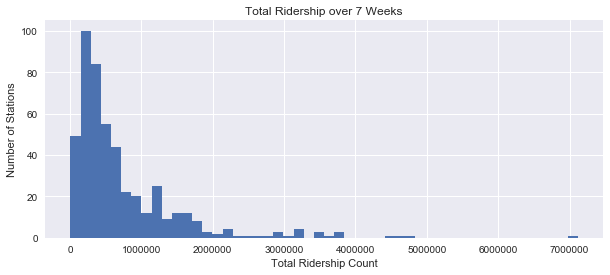

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(stations_summed['total_traffic'],bins = 50);
ax.set_title('Total Ridership over %s Weeks' % len(weeks))
ax.set_ylabel('Number of Stations')
ax.set_xlabel('Total Ridership Count')

In [26]:
# Its a little weird that 14th St Union square has double the ridership of the other stations
# Investigate 125th St and Broadway station again
top_station_rows = (station_daily['unit'] == 'R170') & (station_daily['station'] == '14 ST-UNION SQ')
top_station = station_daily.loc[(top_station_rows)]

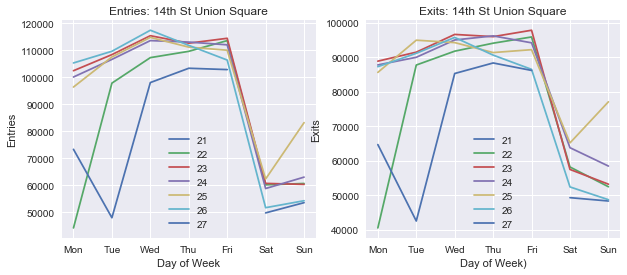

In [27]:
# Plot show no obvious errors. It turns out 42nd st, Times Square is divided into two separate sub-stations,
# but 14th st is not.
make_rainbow_plot(top_station,'14th St Union Square')

# Question 10: Bonus
Bar Chart of 10 busiest stations

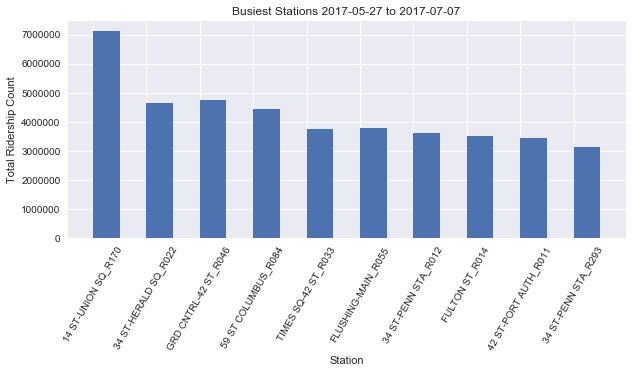

In [28]:
xlabs = stations_summed.iloc[0:10]['station_unit']
yvals = stations_summed.iloc[0:10]['total_traffic']
xvals = range(0,len(yvals))

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(xvals,yvals,
        edgecolor='none',
        width=0.5,
        align='edge',
        label='y1');
ax.set_xticks(xvals);
plt.xticks(rotation = 60)
ax.set_xticklabels(xlabs);
ax.set_xlabel('Station');
ax.set_ylabel('Total Ridership Count');

min_date = str(station_daily['dtime'].min().date())
max_date = str(station_daily['dtime'].max().date())
ax.set_title('Busiest Stations %s to %s' % (min_date,max_date));

# Additional Exploration

## Aggregation by Station

#### Lunch and dinner ridership

* Go back to file aggregation step
* Add in columns where turnstile counts for lunch and dinner
* All non-lunch dinner hours removed
* Group to daily resolution

Note: Lunch is defined as 11AM to 4PM, and dinner as 5PM to midnight (new yorkers tend to keep late hours). We can definitely changes these.

### Stations with greatest total traffic during lunch

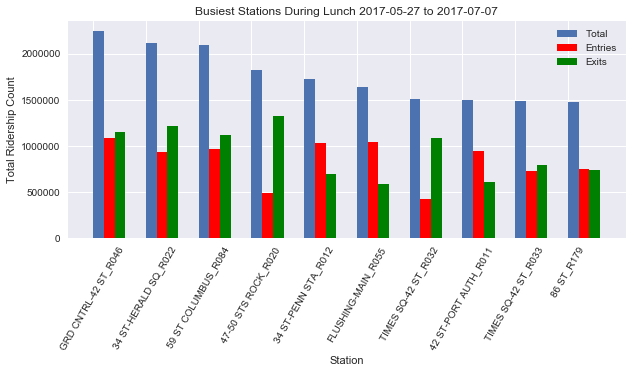

In [29]:

stations_summed_lunch_sorted = stations_summed.sort_values('total_lunch_traffic',ascending=False)

top_group_size = 10
xlabs = stations_summed_lunch_sorted.iloc[0:top_group_size]['station_unit']
yvals_total = stations_summed_lunch_sorted.iloc[0:top_group_size]['total_lunch_traffic']
yvals_entries = stations_summed_lunch_sorted.iloc[0:top_group_size]['lunch_entries']
yvals_exits = stations_summed_lunch_sorted.iloc[0:top_group_size]['lunch_exits']

xvals = np.linspace(0,top_group_size+1,top_group_size)

fig, ax = plt.subplots(figsize=(10, 4))
total_bars = ax.bar(xvals,yvals_total,
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

entry_bars = ax.bar(xvals+0.25,yvals_entries,
            color = 'red',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

exit_bars = ax.bar(xvals+0.50,yvals_exits,
            color = 'green',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1')


ax.set_xticks(xvals);
plt.xticks(rotation = 60)
ax.set_xticklabels(xlabs);
ax.set_xlabel('Station');
ax.set_ylabel('Total Ridership Count');

ax.legend((total_bars[0], entry_bars[0],exit_bars), ('Total', 'Entries','Exits'))


# Title Formating
min_date = str(station_daily['dtime'].min().date())
max_date = str(station_daily['dtime'].max().date())
ax.set_title('Busiest Stations During Lunch %s to %s' % (min_date,max_date));

In chart above, station on the left has the most traffic during lunchtime 

### Stations with Greatest Total Traffic During Dinner

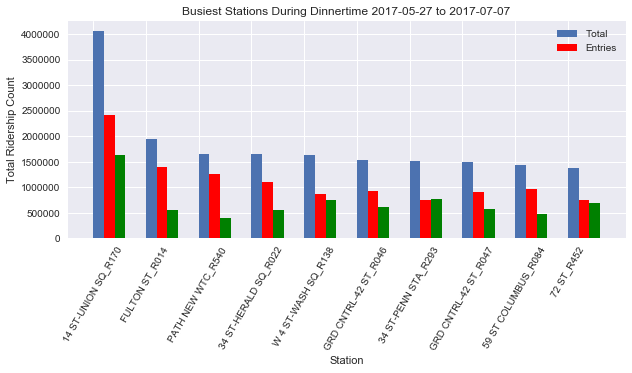

In [30]:
# Dinner Sorted
stations_summed_dinner_sorted = stations_summed.sort_values('total_dinner_traffic',ascending=False)


top_group_size = 10
xlabs = stations_summed_dinner_sorted.iloc[0:top_group_size]['station_unit']
yvals_total = stations_summed_dinner_sorted.iloc[0:top_group_size]['total_dinner_traffic']
yvals_entries = stations_summed_dinner_sorted.iloc[0:top_group_size]['dinner_entries']
yvals_exits = stations_summed_dinner_sorted.iloc[0:top_group_size]['dinner_exits']

xvals = np.linspace(0,top_group_size+1,top_group_size)

fig, ax = plt.subplots(figsize=(10, 4))
total_bars = ax.bar(xvals,yvals_total,
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

entry_bars = ax.bar(xvals+0.25,yvals_entries,
            color = 'red',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

exit_bars = ax.bar(xvals+0.50,yvals_exits,
            color = 'green',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1')


ax.set_xticks(xvals);
plt.xticks(rotation = 60)
ax.set_xticklabels(xlabs);
ax.set_xlabel('Station');
ax.set_ylabel('Total Ridership Count');

ax.legend((total_bars[0], entry_bars[0],exit_bars), ('Total', 'Entries',))


# Title Formating
min_date = str(station_daily['dtime'].min().date())
max_date = str(station_daily['dtime'].max().date())
ax.set_title('Busiest Stations During Dinnertime %s to %s' % (min_date,max_date));

### Stations with most __exits__ during lunchtime

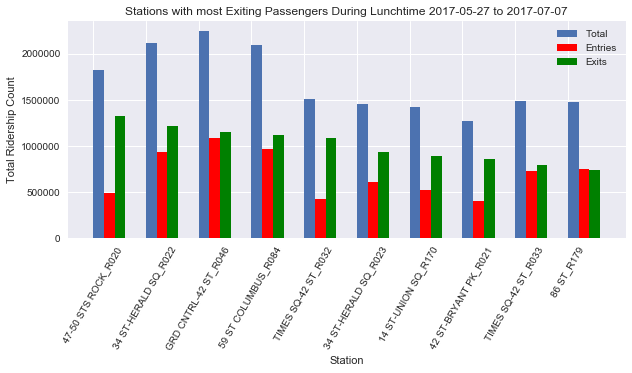

In [31]:
# Dinner Sorted
stations_summed_lunch_exits_sorted = stations_summed.sort_values('lunch_exits',ascending=False)

top_group_size = 10
xlabs = stations_summed_lunch_exits_sorted.iloc[0:top_group_size]['station_unit']
yvals_total = stations_summed_lunch_exits_sorted.iloc[0:top_group_size]['total_lunch_traffic']
yvals_entries = stations_summed_lunch_exits_sorted.iloc[0:top_group_size]['lunch_entries']
yvals_exits = stations_summed_lunch_exits_sorted.iloc[0:top_group_size]['lunch_exits']

xvals = np.linspace(0,top_group_size+1,top_group_size)

fig, ax = plt.subplots(figsize=(10, 4))
total_bars = ax.bar(xvals,yvals_total,
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

entry_bars = ax.bar(xvals+0.25,yvals_entries,
            color = 'red',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

exit_bars = ax.bar(xvals+0.50,yvals_exits,
            color = 'green',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1')


ax.set_xticks(xvals);
plt.xticks(rotation = 60)
ax.set_xticklabels(xlabs);
ax.set_xlabel('Station');
ax.set_ylabel('Total Ridership Count');

ax.legend((total_bars[0], entry_bars[0],exit_bars), ('Total', 'Entries','Exits'))


# Title Formating
min_date = str(station_daily['dtime'].min().date())
max_date = str(station_daily['dtime'].max().date())
ax.set_title('Stations with most Exiting Passengers During Lunchtime %s to %s' % (min_date,max_date));

In chart above, station on the left has the passenger exits during lunchtime. I left the "total" and "entries" columns for reference. Please note that the order of columns (and stations included) is different from the previous lunch-bar chart

### Stations with most __exits__ during dinnertime

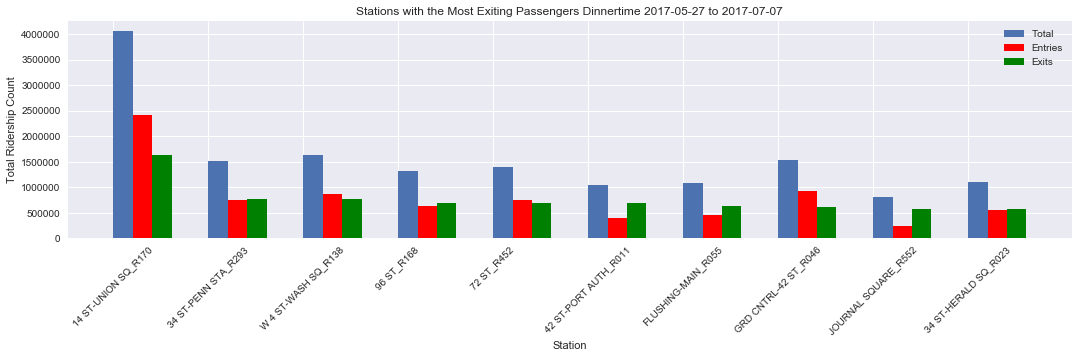

In [32]:
# Dinner Sorted
stations_summed_dinner_exits_sorted = stations_summed.sort_values('dinner_exits',ascending=False)


top_group_size = 10
xlabs = stations_summed_dinner_exits_sorted.iloc[0:top_group_size]['station_unit']
yvals_total = stations_summed_dinner_exits_sorted.iloc[0:top_group_size]['total_dinner_traffic']
yvals_entries = stations_summed_dinner_exits_sorted.iloc[0:top_group_size]['dinner_entries']
yvals_exits = stations_summed_dinner_exits_sorted.iloc[0:top_group_size]['dinner_exits']

xvals = np.linspace(0,top_group_size + 1,top_group_size)

fig, ax = plt.subplots(figsize=(18, 4))
total_bars = ax.bar(xvals,yvals_total,
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

entry_bars = ax.bar(xvals+0.25,yvals_entries,
            color = 'red',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

exit_bars = ax.bar(xvals+0.50,yvals_exits,
            color = 'green',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1')


ax.set_xticks(xvals);
plt.xticks(rotation = 45)
ax.set_xticklabels(xlabs);
ax.set_xlabel('Station');
ax.set_ylabel('Total Ridership Count');

ax.legend((total_bars[0], entry_bars[0],exit_bars), ('Total', 'Entries','Exits'))


# Title Formating
min_date = str(station_daily['dtime'].min().date())
max_date = str(station_daily['dtime'].max().date())
ax.set_title('Stations with the Most Exiting Passengers Dinnertime %s to %s' % (min_date,max_date));

In chart above, station on the left has the passenger exits during dinnertime. I left the "total" and "entries" columns for reference. Please note that the order of columns (and stations included) is different from the previous dinner-bar chart

## Aggregation by Turnstile

#### Total Traffic

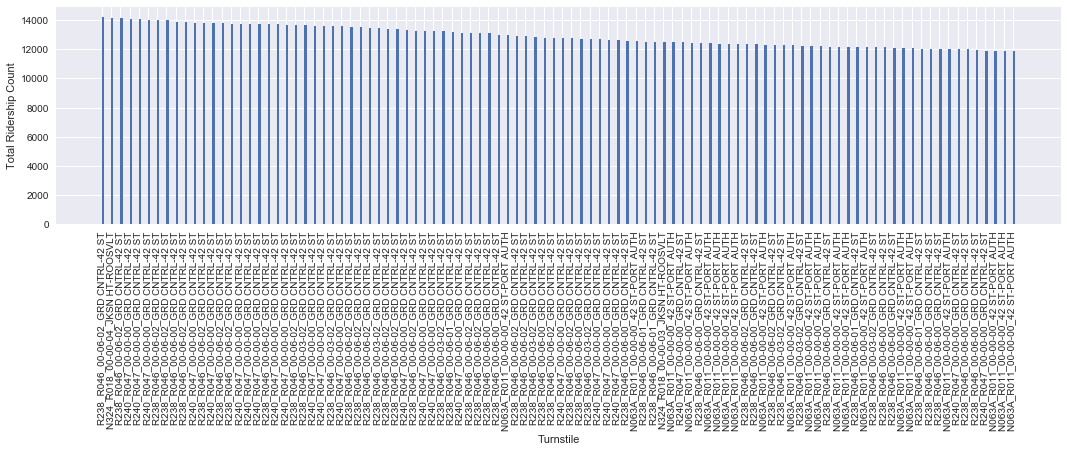

In [33]:
turnstile_total_summed = turnstile_daily.sort_values('total_traffic',ascending=False)
turnstile_total_summed = make_id(turnstile_total_summed)

top_group_size = 100
xlabs = turnstile_total_summed.iloc[0:top_group_size]['id']
yvals_total = turnstile_total_summed.iloc[0:top_group_size]['total_traffic']
yvals_entries = turnstile_total_summed.iloc[0:top_group_size]['total_traffic']
yvals_exits = turnstile_total_summed.iloc[0:top_group_size]['total_traffic']

xvals = np.linspace(0,top_group_size + 1,top_group_size)

fig, ax = plt.subplots(figsize=(18, 4))
total_bars = ax.bar(xvals,yvals_total,
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1')


ax.set_xticks(xvals);
plt.xticks(rotation = 90)
ax.set_xticklabels(xlabs);
ax.set_xlabel('Turnstile');
ax.set_ylabel('Total Ridership Count');

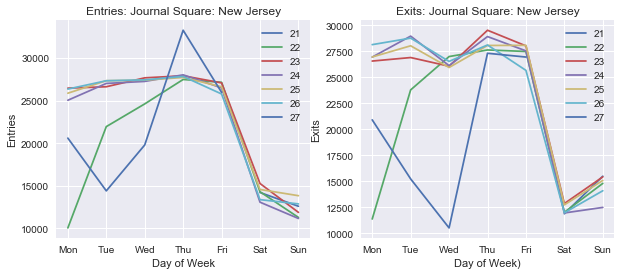

In [34]:
# Really?! Journal Square, New Jersey. That seems odd. 
top_station_rows = (station_daily['unit'] == 'R552') & (station_daily['station'] == 'JOURNAL SQUARE')
top_station = station_daily.loc[(top_station_rows)]
make_rainbow_plot(top_station,'Journal Square: New Jersey')

Maybe the spike are real(possibly failure on another turnstile causing this bottleneck), maybe they aren't. Regardless, even if these spike are removed, this will still be the most used turnstile by a landslide.



#### Total Traffic at Dinner Time

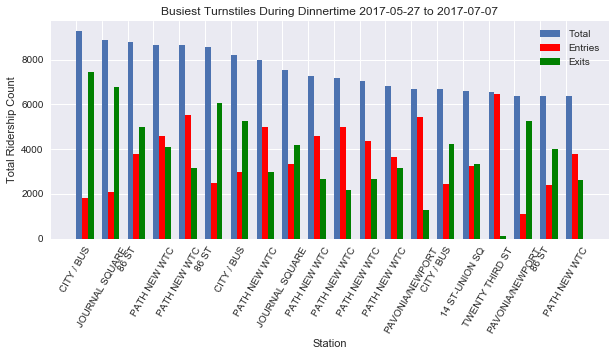

In [35]:
# Dinner Sorted
turnstile_summed_dinner_sorted = turnstile_daily.sort_values('total_dinner_traffic',ascending=False)

top_group_size = 20
xlabs = turnstile_summed_dinner_sorted.iloc[0:top_group_size]['station']
yvals_total = turnstile_summed_dinner_sorted.iloc[0:top_group_size]['total_dinner_traffic']
yvals_entries = turnstile_summed_dinner_sorted.iloc[0:top_group_size]['dinner_entries']
yvals_exits = turnstile_summed_dinner_sorted.iloc[0:top_group_size]['dinner_exits']

xvals = np.linspace(0,top_group_size+1,top_group_size)

fig, ax = plt.subplots(figsize=(10, 4))
total_bars = ax.bar(xvals,yvals_total,
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

entry_bars = ax.bar(xvals+0.25,yvals_entries,
            color = 'red',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1');

exit_bars = ax.bar(xvals+0.50,yvals_exits,
            color = 'green',
            edgecolor='none',
            width=0.25,
            align='edge',
            label='y1')


ax.set_xticks(xvals);
plt.xticks(rotation = 60)
ax.set_xticklabels(xlabs);
ax.set_xlabel('Station');
ax.set_ylabel('Total Ridership Count');

ax.legend((total_bars[0], entry_bars[0],exit_bars), ('Total', 'Entries','Exits'))


# Title Formating
min_date = str(station_daily['dtime'].min().date())
max_date = str(station_daily['dtime'].max().date())
ax.set_title('Busiest Turnstiles During Dinnertime %s to %s' % (min_date,max_date));

In [36]:
len(nyc_df.unit.unique())

466

In [37]:
journal_square_df = nyc_df[nyc_df.station == 'JOURNAL SQUARE'].groupby(['id','readtime']).sum().reset_index()

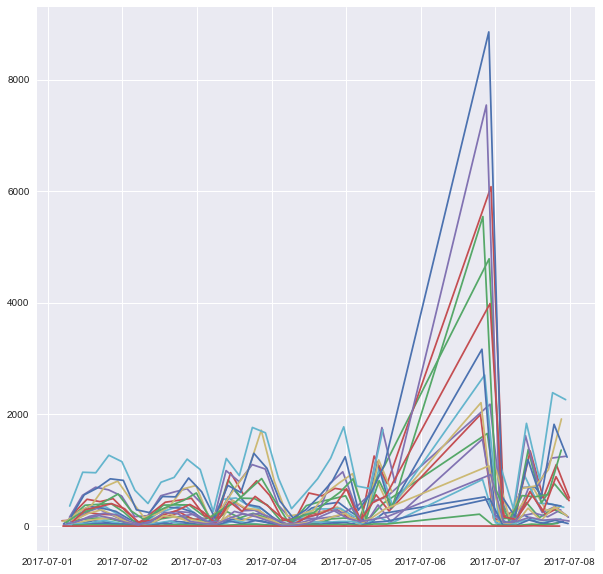

In [38]:
js_id_list = journal_square_df.id.unique()


fig, ax = plt.subplots(figsize=(10, 10))
for val in js_id_list:
    mini_df = journal_square_df[journal_square_df['id'] == val]
    plt.plot(mini_df['readtime'],mini_df['total_traffic'])

In [39]:
journal_square_df

,id,readtime,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,total_traffic,lunch_entries,lunch_exits,dinner_entries,dinner_exits,total_lunch_traffic,total_dinner_traffic,lines_at_station
0,PTH03_R552_00-00-00_JOURNAL SQUARE,2017-07-01 01:51:35,297343,68297,-3.806e+06,-3.254e+06,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1
1,PTH03_R552_00-00-00_JOURNAL SQUARE,2017-07-01 06:03:35,297346,68349,3.000e+00,5.200e+01,3.0,52.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,PTH03_R552_00-00-00_JOURNAL SQUARE,2017-07-01 10:15:35,297369,68365,2.300e+01,1.600e+01,23.0,16.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,PTH03_R552_00-00-00_JOURNAL SQUARE,2017-07-01 14:27:35,297441,68390,7.200e+01,2.500e+01,72.0,25.0,97.0,72.0,25.0,0.0,0.0,97.0,0.0,1
4,PTH03_R552_00-00-00_JOURNAL SQUARE,2017-07-01 18:39:35,297489,68411,4.800e+01,2.100e+01,48.0,21.0,69.0,0.0,0.0,48.0,21.0,0.0,69.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,PTH03_R552_00-02-01_JOURNAL SQUARE,2017-07-07 06:53:48,106845,121946,2.500e+01,5.800e+01,25.0,58.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,1
731,PTH03_R552_00-02-01_JOURNAL SQUARE,2017-07-07 11:05:48,106935,122014,9.000e+01,6.800e+01,90.0,68.0,158.0,90.0,68.0,0.0,0.0,158.0,0.0,1
732,PTH03_R552_00-02-01_JOURNAL SQUARE,2017-07-07 15:17:48,106991,122062,5.600e+01,4.800e+01,56.0,48.0,104.0,56.0,48.0,0.0,0.0,104.0,0.0,1
733,PTH03_R552_00-02-01_JOURNAL SQUARE,2017-07-07 19:29:48,107054,122124,6.300e+01,6.200e+01,63.0,62.0,125.0,0.0,0.0,63.0,62.0,0.0,125.0,1


In [40]:
nyc_df['lines_at_station'] = nyc_df.linename.apply(len)

In [61]:
gb = total_df_cleaned.groupby(['unit','station'])
test_df = gb.sum()
test_df['lines_at_station'] = gb.mean()['lines_at_station']

test_df['total_traffic_norm'] = test_df['total_traffic']/test_df['lines_at_station']
test_df.sort_values('total_traffic_norm', ascending=False).iloc[0:10]

,,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,total_traffic,lunch_entries,lunch_exits,dinner_entries,dinner_exits,total_lunch_traffic,total_dinner_traffic,lines_at_station,total_traffic_norm
unit,station,,,,,,,,,,,,,,,
R055,FLUSHING-MAIN,49060817023,48109114558,-9.618e+06,-1.496e+07,2.141e+06,1.666e+06,3.807e+06,1.048e+06,593193.0,4.662e+05,624951.0,1.641e+06,1.091e+06,1.0,3.807e+06
R540,PATH NEW WTC,1013248537,1071018328,-1.322e+07,-4.562e+06,1.822e+06,1.676e+06,3.498e+06,2.864e+05,642914.0,1.256e+06,398035.0,9.293e+05,1.653e+06,1.0,3.498e+06
R235,BEDFORD AV,67574014019,25443259680,1.338e+06,1.521e+06,1.057e+06,1.138e+06,2.195e+06,5.047e+05,405313.0,2.723e+05,450244.0,9.100e+05,7.225e+05,1.0,2.195e+06
R552,JOURNAL SQUARE,1584144385,1400110763,-2.394e+07,-1.917e+07,9.234e+05,9.289e+05,1.849e+06,3.465e+05,141513.0,2.358e+05,581603.0,4.880e+05,8.136e+05,1.0,1.849e+06
R178,77 ST,61000840490,22279255441,7.816e+08,1.015e+08,9.055e+05,9.047e+05,1.810e+06,1.659e+05,238120.0,5.449e+05,406758.0,4.041e+05,9.517e+05,1.0,1.810e+06
R570,72 ST-2 AVE,30746773303,1045824327,-7.361e+09,-1.155e+10,9.518e+05,8.323e+05,1.784e+06,1.745e+05,176107.0,5.612e+05,377057.0,3.506e+05,9.383e+05,1.0,1.784e+06
R176,33 ST,124438929194,36831150743,6.445e+08,1.869e+06,9.928e+05,7.706e+05,1.763e+06,1.828e+05,215303.0,6.120e+05,339959.0,3.981e+05,9.519e+05,1.0,1.763e+06
R116,50 ST,21943027883,21362584611,-3.060e+06,1.736e+08,8.476e+05,8.122e+05,1.660e+06,2.709e+05,470738.0,3.928e+05,181334.0,7.416e+05,5.741e+05,1.0,1.660e+06
R541,THIRTY THIRD ST,2393005385,1697192465,1.350e+06,-4.782e+06,8.747e+05,6.952e+05,1.570e+06,1.465e+05,264325.0,5.714e+05,192858.0,4.108e+05,7.642e+05,1.0,1.570e+06
